In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
runlist = np.arange(157,163,1)
#runlist = [790, 791, 792]
Loaddir = '../Claudio/Reduced_RIXS/'
##############################################3
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 6 runs: [157 158 159 160 161 162] from ../Claudio/Reduced_RIXS/


## check data files

In [3]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*RIXS*'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
datafiles

[157 158 159 160 161 162]
48 files found


['../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi1_ON.npy',
 '../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi2_ON.npy',
 '../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi3_ON.npy',
 '../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi4_ON.npy',
 '../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi1_OFF.npy',
 '../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi2_OFF.npy',
 '../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi3_OFF.npy',
 '../Claudio/Reduced_RIXS/run0157-FePhen_RXES_2ps_loop_001/RIXS_roi4_OFF.npy',
 '../Claudio/Reduced_RIXS/run0158-FePhen_RXES_2ps_loop_002/RIXS_roi1_ON.npy',
 '../Claudio/Reduced_RIXS/run0158-FePhen_RXES_2ps_loop_002/RIXS_roi2_ON.npy',
 '../Claudio/Reduced_RIXS/run0158-FePhen_RXES_2ps_loop_002/RIXS_roi3_ON.npy',
 '../Claudio/Reduced_RIXS/run0158-FePhen_RXES_2ps_loop_002/RIXS_roi4_ON.npy',
 '../Claudio/Reduced_RIXS/run0158-FePhen_RXES_2ps_loop_002/R

# Plotting RIXS planes
### load and average data

In [4]:
roi_array = ['RIXS_roi1_ON', 'RIXS_roi1_OFF', 
             'RIXS_roi2_ON', 'RIXS_roi2_OFF',
             'RIXS_roi3_ON', 'RIXS_roi3_OFF',
             'RIXS_roi4_ON', 'RIXS_roi4_OFF',]

for spec in roi_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    patch = datafiles
    rixs2save = 0
    temp = []
    for ff in patch:
        temp.append(np.load(ff, allow_pickle=True))
    rixs2save = np.average(temp,axis = 0)
    print (len(patch), spec, np.shape(rixs2save))
    np.save(Loaddir+spec+'_all.npy', rixs2save)

6 RIXS_roi1_ON (121, 150)
6 RIXS_roi1_OFF (121, 150)
6 RIXS_roi2_ON (121, 150)
6 RIXS_roi2_OFF (121, 150)
6 RIXS_roi3_ON (121, 140)
6 RIXS_roi3_OFF (121, 140)
6 RIXS_roi4_ON (121, 140)
6 RIXS_roi4_OFF (121, 140)


In [5]:
RIXS_roi1_ON = np.load(Loaddir+'/RIXS_roi1_ON_all.npy')
RIXS_roi1_OFF = np.load(Loaddir+'/RIXS_roi1_OFF_all.npy')
RIXS_roi2_ON = np.load(Loaddir+'/RIXS_roi2_ON_all.npy')
RIXS_roi2_OFF = np.load(Loaddir+'/RIXS_roi2_OFF_all.npy')
RIXS_roi3_ON = np.load(Loaddir+'/RIXS_roi3_ON_all.npy')
RIXS_roi3_OFF = np.load(Loaddir+'/RIXS_roi3_OFF_all.npy')
RIXS_roi4_ON = np.load(Loaddir+'/RIXS_roi4_ON_all.npy')
RIXS_roi4_OFF = np.load(Loaddir+'/RIXS_roi4_OFF_all.npy')

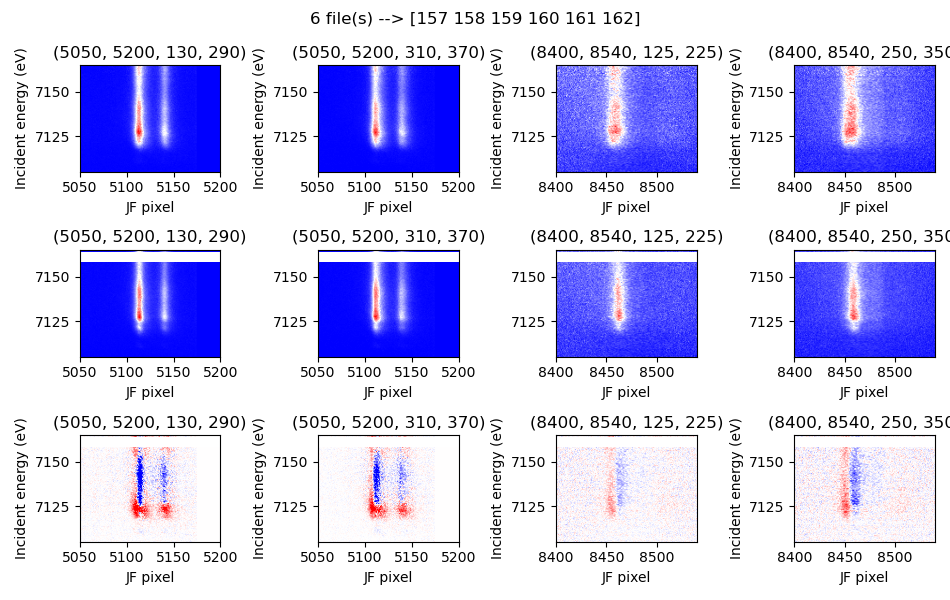

In [6]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

roi1 = (5050, 5200, 130, 290) #signal CRY2 low
roi2 = (5050, 5200, 310, 370) #signan CRY2 up

roi3 = (8400, 8540, 125, 225) #signal CRY1 low
roi4 = (8400, 8540, 250, 350) #signal CRY1 up

RIXS_ON_array = [RIXS_roi1_ON, RIXS_roi2_ON, RIXS_roi3_ON, RIXS_roi4_ON]
RIXS_OFF_array = [RIXS_roi1_OFF, RIXS_roi2_OFF, RIXS_roi3_OFF, RIXS_roi4_OFF]
roiarray = [roi1, roi2, roi3, roi4]

ff = glob.glob(Loaddir+'/*{}*/energy_eV.npy'.format(runlist[0]))
Energy_eV = np.load(ff[0])

for i in range(4):

    RIXS_roi_ON = RIXS_ON_array[i]
    RIXS_roi_OFF = RIXS_OFF_array[i]
    roi = roiarray[i]

    #location = 341+i  # this is to index the position of the subplot
    ax = plt.subplot2grid((3,4),(0,i))
    ax.imshow(RIXS_roi_ON,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[roi[0], roi[1], Energy_eV[0], Energy_eV[-1]])#, vmin=0, vmax=100)
    ax.set_xlabel('JF pixel')
    ax.set_ylabel('Incident energy (eV)')
    ax.set_title(str(roiarray[i]))

    #location2 = 345+i  # this is to index the position of the subplot
    ax2 = plt.subplot2grid((3,4),(1,i))
    ax2.imshow(RIXS_roi_OFF,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[roi[0], roi[1], Energy_eV[0], Energy_eV[-1]])#, vmin=0, vmax=100)
    ax2.set_xlabel('JF pixel')
    ax.set_ylabel('Incident energy (eV)')
    ax2.set_title(str(roiarray[i]))

    #location3 = 349+i  # this is to index the position of the subplot
    ax3 = plt.subplot2grid((3,4),(2,i))
    ax3.imshow(RIXS_roi_ON - RIXS_roi_OFF,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[roi[0], roi[1], Energy_eV[0], Energy_eV[-1]], vmin=-0.1, vmax=0.1)
    ax3.set_xlabel('JF pixel')
    ax3.set_ylabel('Incident energy (eV)')
    ax3.set_title(str(roiarray[i]))

plt.tight_layout()

In [80]:
chosenROI = 4

########################################################################

RIXS_ON_array = [RIXS_roi1_ON, RIXS_roi2_ON, RIXS_roi3_ON, RIXS_roi4_ON]
RIXS_OFF_array = [RIXS_roi1_OFF, RIXS_roi2_OFF, RIXS_roi3_OFF, RIXS_roi4_OFF]
roiarray = [roi1, roi2, roi3, roi4]

RIXS_roi_ON = RIXS_ON_array[chosenROI-1]
RIXS_roi_OFF = RIXS_OFF_array[chosenROI-1]
roi = roiarray[chosenROI-1]


In [121]:
Energy_eV[55]

7132.54206014657

In [100]:
np.shape(RIXS_roi_ON)

(121, 140)

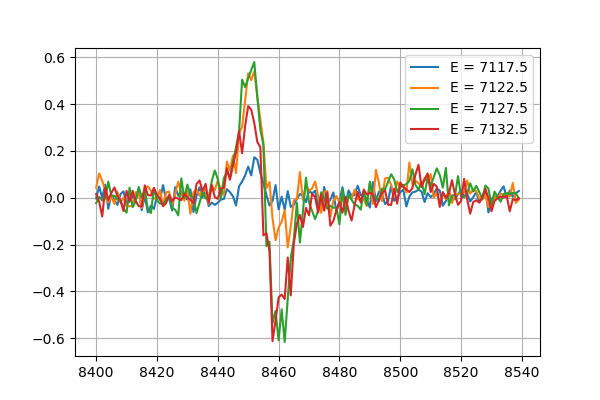

In [125]:
plt.figure(figsize=(6, 4))
offset=0
#plt.plot(np.arange(roi[0], roi[1]), np.nansum(RIXS_roi_ON, axis=0), label = 'ON')
#plt.plot(np.arange(roi[0], roi[1]), np.nansum(RIXS_roi_OFF,axis=0), label = 'OFF')
#plt.plot(np.arange(roi[0], roi[1]), (RIXS_roi_ON-RIXS_roi_OFF)[0], label = 'ON-OFF')
plt.plot(np.arange(roi[0], roi[1]), np.nansum((RIXS_roi_ON-RIXS_roi_OFF)[20:30], axis=0), label = 'E = 7117.5')
plt.plot(np.arange(roi[0], roi[1]), np.nansum((RIXS_roi_ON-RIXS_roi_OFF)[30:40], axis=0), label = 'E = 7122.5')
plt.plot(np.arange(roi[0], roi[1]), np.nansum((RIXS_roi_ON-RIXS_roi_OFF)[40:50], axis=0), label = 'E = 7127.5')
plt.plot(np.arange(roi[0], roi[1]), np.nansum((RIXS_roi_ON-RIXS_roi_OFF)[50:60], axis=0), label = 'E = 7132.5')
plt.legend(loc='best')
#plt.xlabel('emission energy (JF pixel)')
plt.grid()
plt.show()

#ax.set_xlabel('Incident energy (eV)')
#ax.set_ylabel('Emission energy (eV)')
plt.savefig('/das/work/p20/p20537/Claudio/PNG/Kb_lineprofiles.PNG')

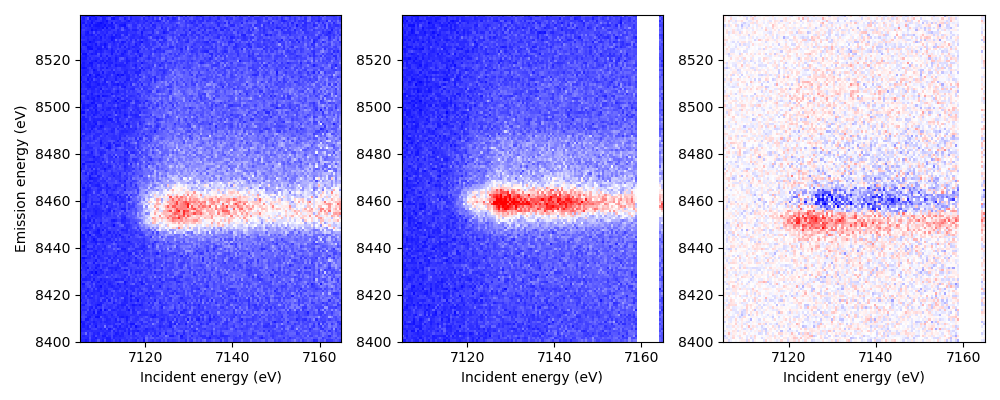

In [124]:
chosenROI = 4

########################################################################
fig = plt.figure(figsize=(10, 4))
#plt.suptitle(fc.selected.split('/')[-3])

RIXS_ON_array = [RIXS_roi1_ON, RIXS_roi2_ON, RIXS_roi3_ON, RIXS_roi4_ON]
RIXS_OFF_array = [RIXS_roi1_OFF, RIXS_roi2_OFF, RIXS_roi3_OFF, RIXS_roi4_OFF]
roiarray = [roi1, roi2, roi3, roi4]

RIXS_roi_ON = RIXS_ON_array[chosenROI-1]
RIXS_roi_OFF = RIXS_OFF_array[chosenROI-1]
roi = roiarray[chosenROI-1]

ax = plt.subplot(131)
ax.pcolormesh(Energy_eV, np.arange(roi[0], roi[1]), RIXS_roi_ON.T, cmap='bwr', vmin = 0, vmax = 0.2)
ax.set_xlabel('Incident energy (eV)')
ax.set_ylabel('Emission energy (eV)')

ax = plt.subplot(132)
ax.pcolormesh(Energy_eV, np.arange(roi[0], roi[1]), RIXS_roi_OFF.T, cmap='bwr',  vmin = 0, vmax = 0.2)
ax.set_xlabel('Incident energy (eV)')

ax = plt.subplot(133)
ax.pcolormesh(Energy_eV, np.arange(roi[0], roi[1]), (RIXS_roi_ON-RIXS_roi_OFF).T, cmap='bwr',  vmin = -0.1, vmax = 0.1)
ax.set_xlabel('Incident energy (eV)')

plt.tight_layout()
plt.savefig('/das/work/p20/p20537/Claudio/PNG/Kb_2D.PNG')

In [23]:
np.shape(RIXS_roi1_ON)

(121, 150)

In [25]:
np.shape(Energy_eV)

(121,)

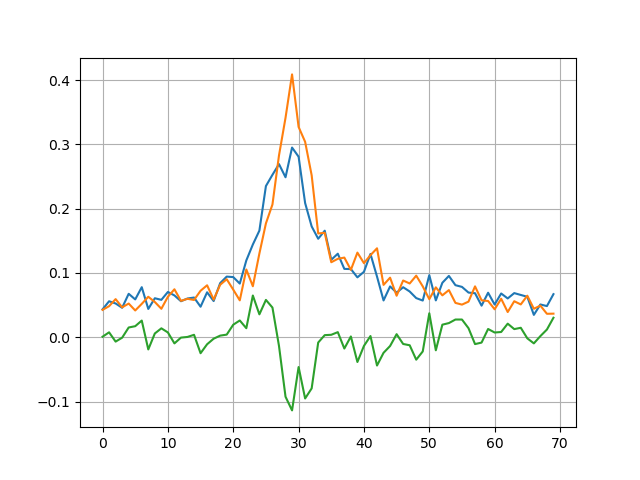

In [7]:
chosenenergy = 7130

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosenenergy)][0]

axis_rebin, spectrum_rebin_ON, _, _ = plot_tool_static(RIXS_roi4_ON[index_energy,:], np.arange(roi[0], roi[1]+1), 2)
axis_rebin, spectrum_rebin_OFF, _, _ = plot_tool_static(RIXS_roi4_OFF[index_energy,:], np.arange(roi[0], roi[1]+1), 2)


plt.figure()
plt.plot(spectrum_rebin_ON)
plt.plot(spectrum_rebin_OFF)
plt.plot((spectrum_rebin_ON - spectrum_rebin_OFF))
plt.grid()
plt.show()